In [228]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#Machine Learning imports 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, Lasso, RandomizedLasso
from sklearn.cluster import KMeans

from minepy import MINE
from scipy.stats import boxcox

from sklearn.cross_validation import train_test_split
from sklearn import metrics

from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import RFE

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import skew

In [673]:
train = pd.read_csv("ad_org_train.csv")
test = pd.read_csv("ad_org_test.csv")
train.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


In [674]:
columns = ['views', 'likes', 'dislikes', 'comment']
for column in columns:
        train[column] = train[column].apply(pd.to_numeric, errors = 'coerce')
        test[column] = test[column].apply(pd.to_numeric, errors = 'coerce')        
        print (column, train[column].isnull().sum())
        print (column, test[column].isnull().sum())

views 2
views 1
likes 155
likes 88
dislikes 155
dislikes 88
comment 233
comment 151


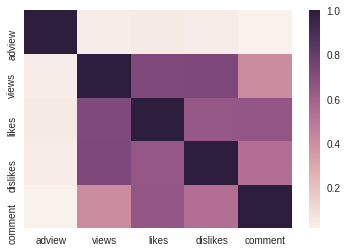

In [675]:
sns.heatmap(train.corr())

In [676]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [677]:
def time_transform(data):
    duration = data['duration']
    h_pos = 0
    m_pos = 0
    s_pos = len(duration) - 1
    time = 0
    #duration = list(duration)
    if 'H' in duration:
        for i in range(2,len(duration)):
            if duration[i] == 'H':
                h_pos = i
                break
        time = int(duration[2:h_pos]) * 3600 

    if 'M' in duration:
        for i in range(2,len(duration)):
            if duration[i] == 'M':
                m_pos = i
                break
        if 'H' in duration:
            time = time + int(duration[h_pos+1:m_pos]) * 60
        else:
            time = int(duration[2:m_pos]) * 60
        
        if 'S' in duration:
            time = time + int(duration[m_pos+1:s_pos])
        
    else:
        if 'H' not in duration:
            time = time + int(duration[2:s_pos])
        else:
            time = time + int(duration[h_pos+1:s_pos])
    #print (duration, m_pos)
    #time = str(time)
    #print (time)
    data['duration'] = time
    data.head()
    return data

train = train.apply(time_transform, axis=1)
test = test.apply(time_transform, axis=1)

In [678]:
dummies = pd.get_dummies(train.category)
train = train.join(dummies)
test = test.join(dummies)

In [679]:
train.drop(['category'], axis=1,inplace=True)
test.drop(['category'],axis=1, inplace=True)
train.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,A,B,C,D,E,F,G,H
0,VID_18655,40,1031602.0,8523.0,363.0,1095.0,2016-09-14,457,0,0,0,0,0,1,0,0
1,VID_14135,2,1707.0,56.0,2.0,6.0,2016-10-01,570,0,0,0,1,0,0,0,0
2,VID_2187,1,2023.0,25.0,0.0,2.0,2016-07-02,136,0,0,1,0,0,0,0,0
3,VID_23096,6,620860.0,777.0,161.0,153.0,2016-07-27,262,0,0,0,0,0,0,0,1
4,VID_10175,1,666.0,1.0,0.0,0.0,2016-06-29,31,0,0,0,1,0,0,0,0


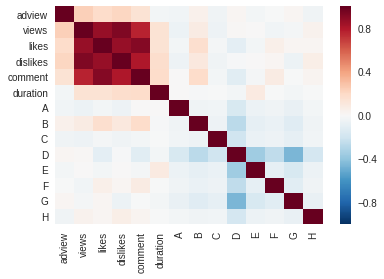

In [662]:
sns.heatmap(train.corr(method='spearman'))

In [680]:
train.corr(method='spearman')

,adview,views,likes,dislikes,comment,duration,A,B,C,D,E,F,G,H
adview,1.000000,0.237642,0.185938,0.214008,0.144622,-0.030875,-0.036865,0.047345,-0.042085,0.018129,-0.023920,-0.000059,0.019098,-0.040601
views,0.237642,1.000000,0.872814,0.930303,0.769998,0.142677,-0.060725,0.082058,-0.048486,0.008746,0.006108,-0.035694,-0.019411,0.046149
likes,0.185938,0.872814,1.000000,0.873085,0.916827,0.142274,-0.029646,0.165609,-0.022554,-0.096843,-0.029013,0.058859,0.020588,0.020707
dislikes,0.214008,0.930303,0.873085,1.000000,0.811613,0.176438,-0.052674,0.103889,-0.042374,-0.010300,0.001293,0.022446,-0.055082,0.062508
comment,0.144622,0.769998,0.916827,0.811613,1.000000,0.183926,0.001486,0.182019,-0.025496,-0.116202,-0.017541,0.084194,-0.005386,0.029607
duration,-0.030875,0.142677,0.142274,0.176438,0.183926,1.000000,0.005113,-0.013426,-0.001295,-0.028253,0.090534,-0.004771,-0.026744,-0.000883
A,-0.036865,-0.060725,-0.029646,-0.052674,0.001486,0.005113,1.000000,-0.042183,-0.031464,-0.159742,-0.055412,-0.040023,-0.071395,-0.027249
B,0.047345,0.082058,0.165609,0.103889,0.182019,-0.013426,-0.042183,1.000000,-0.052938,-0.268768,-0.093232,-0.067339,-0.120122,-0.045846
C,-0.042085,-0.048486,-0.022554,-0.042374,-0.025496,-0.001295,-0.031464,-0.052938,1.000000,-0.200469,-0.069540,-0.050227,-0.089597,-0.034196
D,0.018129,0.008746,-0.096843,-0.010300,-0.116202,-0.028253,-0.159742,-0.268768,-0.200469,1.000000,-0.353054,-0.255003,-0.454885,-0.173612


lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['category'].values))
train['category'] = lbl.transform(list(train['category'].values))
test['category'] = lbl.transform(list(test['category'].values))

In [681]:
train['published'] = pd.to_datetime(train['published'])
test['published'] = pd.to_datetime(test['published'])

train['dayofweek'] = train.published.dt.dayofweek
test['dayofweek'] = test.published.dt.dayofweek
#quarter didn't work
#weekofyear didn't work

train['year'] = train.published.dt.year
test['year'] = test.published.dt.year

train['month'] = train.published.dt.month
test['month'] = test.published.dt.month

train.drop(['published'], axis=1, inplace=True)
test.drop(['published'], axis=1, inplace=True)

In [682]:
test.drop(['vidid'], axis=1, inplace=True)
train.drop(['vidid'], axis=1, inplace=True)

In [683]:
train.head()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,E,F,G,H,dayofweek,year,month
0,40,1031602.0,8523.0,363.0,1095.0,457,0,0,0,0,0,1,0,0,2,2016,9
1,2,1707.0,56.0,2.0,6.0,570,0,0,0,1,0,0,0,0,5,2016,10
2,1,2023.0,25.0,0.0,2.0,136,0,0,1,0,0,0,0,0,5,2016,7
3,6,620860.0,777.0,161.0,153.0,262,0,0,0,0,0,0,0,1,2,2016,7
4,1,666.0,1.0,0.0,0.0,31,0,0,0,1,0,0,0,0,2,2016,6


In [667]:
train.describe()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,E,F,G,H,dayofweek,year,month
count,1.463700e+04,1.463700e+04,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000
mean,2.066030e+03,7.112280e+05,2785.841293,254.429391,409.135547,1040.179067,0.024459,0.066270,0.037986,0.504407,0.109107,0.060053,0.168955,0.028763,2.777960,2014.437521,6.643848
std,5.282706e+04,2.731475e+06,8938.490736,1029.774864,1511.176934,2316.818747,0.154473,0.248763,0.191169,0.499998,0.311784,0.237594,0.374725,0.167145,1.905286,1.770521,3.291857
min,1.000000e+00,4.900000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2005.000000,1.000000
25%,1.000000e+00,3.151700e+04,88.000000,7.000000,7.000000,187.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2013.000000,4.000000
50%,2.000000e+00,1.586680e+05,450.000000,38.000000,46.000000,325.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2015.000000,7.000000
75%,6.000000e+00,5.836130e+05,1863.000000,167.000000,224.000000,723.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2016.000000,9.000000
max,5.429665e+06,1.380479e+08,283824.000000,49449.000000,75045.000000,42317.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,2017.000000,12.000000


In [687]:
temp = train.loc[train.adview >= 0]
train = temp.loc[temp.adview <= 20000]

In [684]:
train.describe()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,E,F,G,H,dayofweek,year,month
count,1.463700e+04,1.463700e+04,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000
mean,2.066030e+03,7.112280e+05,2785.841293,254.429391,409.135547,1040.179067,0.024459,0.066270,0.037986,0.504407,0.109107,0.060053,0.168955,0.028763,2.777960,2014.437521,6.643848
std,5.282706e+04,2.731475e+06,8938.490736,1029.774864,1511.176934,2316.818747,0.154473,0.248763,0.191169,0.499998,0.311784,0.237594,0.374725,0.167145,1.905286,1.770521,3.291857
min,1.000000e+00,4.900000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2005.000000,1.000000
25%,1.000000e+00,3.151700e+04,88.000000,7.000000,7.000000,187.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2013.000000,4.000000
50%,2.000000e+00,1.586680e+05,450.000000,38.000000,46.000000,325.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2015.000000,7.000000
75%,6.000000e+00,5.836130e+05,1863.000000,167.000000,224.000000,723.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2016.000000,9.000000
max,5.429665e+06,1.380479e+08,283824.000000,49449.000000,75045.000000,42317.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,2017.000000,12.000000


columns = ['adview', 'views', 'likes', 'dislikes', 'comment']
for x in columns:
    temp = train[x]
    mean = temp.mean()
    std = temp.std()
    final_list = [z for z in temp if (z > mean - 4 * std)]
    final_list = [z for z in final_list if (z < mean + 4*std)]
    temp = Series(final_list)
    train[x] = temp
    print (x, train[x].isnull().sum())

poly = PolynomialFeatures(degree=2,interaction_only=True)

columns = ['views', 'likes', 'dislikes', 'comment', 'duration']

z_train = poly.fit_transform(train[columns])

z_train = pd.DataFrame(z_train)

z_train.head()

In [688]:
columns = ['adview','views', 'likes', 'dislikes', 'comment', 'duration']

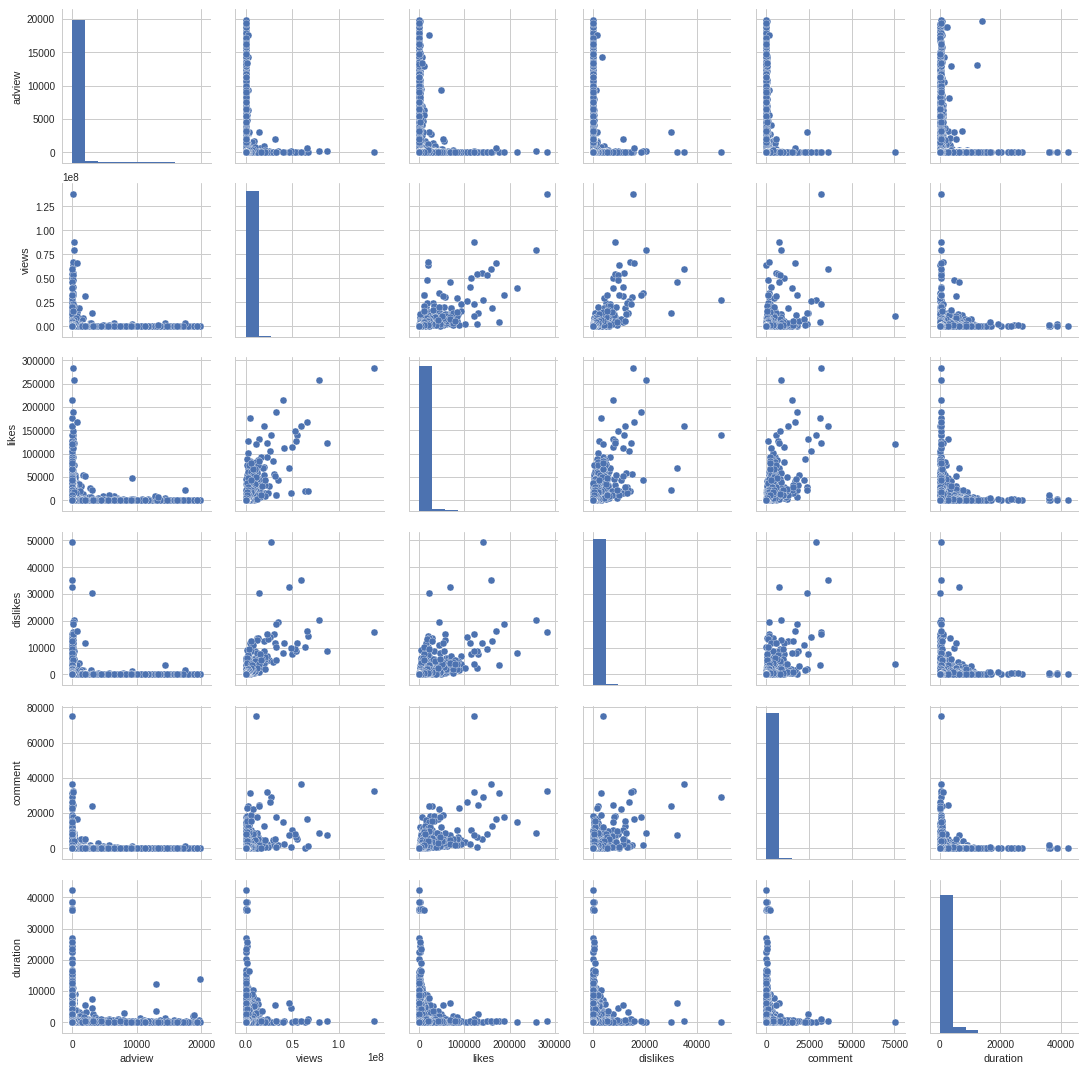

In [689]:
sns.pairplot(train[columns])

std_scaler = preprocessing.StandardScaler()
std_scaler.fit(train[columns])
train[columns] = std_scaler.transform(train[columns])

for x in columns:
    #train[x] = np.log1p(train[x])
    temp = boxcox([train[x]]+1)[0]
    train[x] = temp

In [650]:
train['adview'] = boxcox(train['adview']+1)[0]
train['views'] = boxcox(train['views']+1)[0]
train['likes'] = boxcox(train['likes']+1)[0]
train['dislikes'] = boxcox(train['dislikes']+1)[0]
train['comment'] = boxcox(train['comment']+1)[0]
train['duration'] = boxcox(train['duration']+1)[0]


/home/raunaq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/raunaq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raunaq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

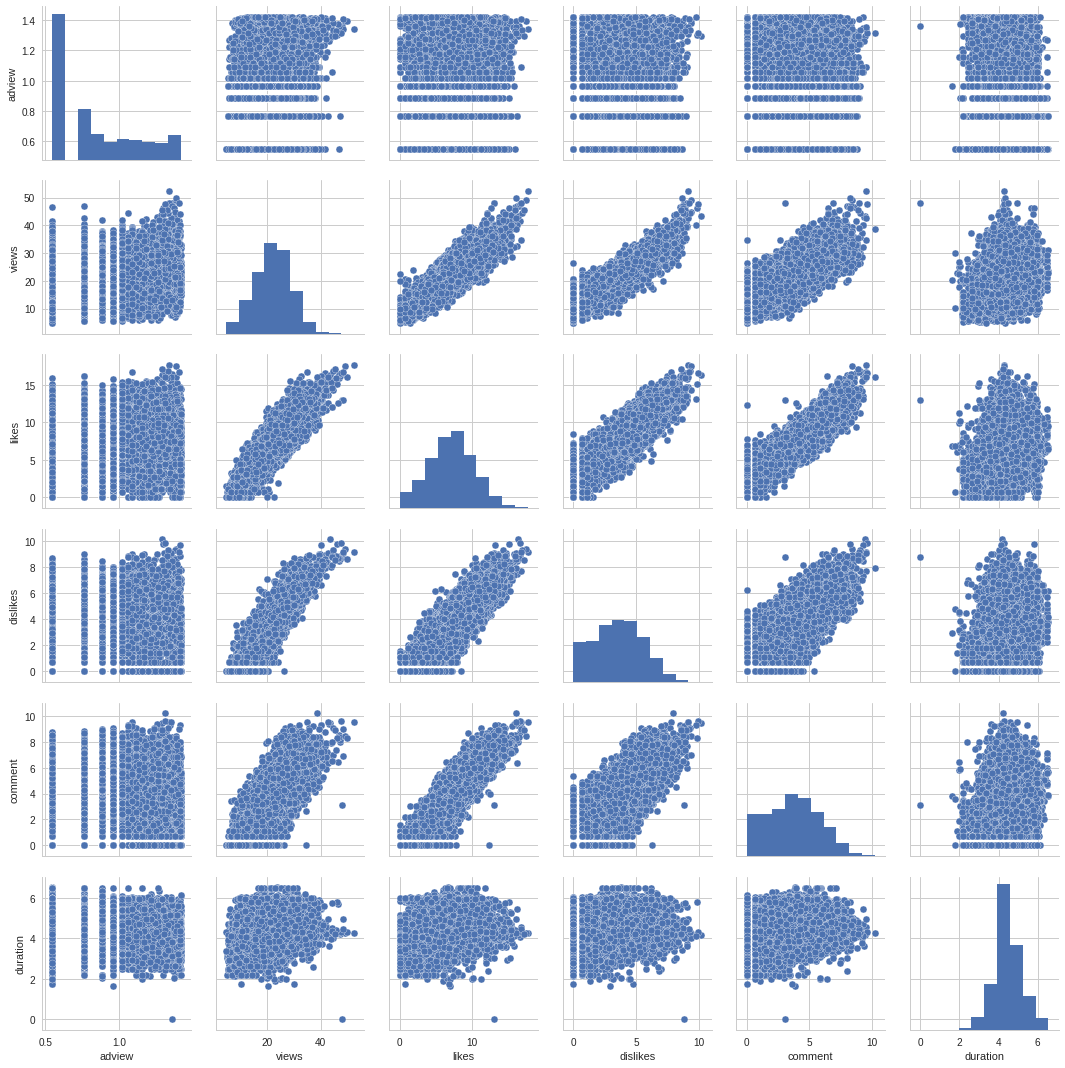

In [651]:
sns.pairplot(train[columns])

In [652]:
train.describe()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,E,F,G,H,dayofweek,year,month
count,14476.000000,14476.000000,14476.000000,14476.000000,14476.000000,14476.000000,14476.000000,14476.000000,14476.000000,14476.000000,14476.000000,14476.000000,14476.000000,14476.000000,14476.000000,14476.000000,14476.000000
mean,0.821970,22.173392,7.137780,3.533099,3.663089,4.450863,0.024454,0.065971,0.037994,0.504836,0.109008,0.059892,0.168762,0.029083,2.778392,2014.423114,6.636502
std,0.290107,6.687285,3.055686,1.972694,2.102545,0.695865,0.154460,0.248240,0.191188,0.499994,0.311660,0.237295,0.374555,0.168044,1.907952,1.772977,3.288723
min,0.548662,4.745449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2005.000000,1.000000
25%,0.548662,17.671109,5.065861,2.055653,2.157774,4.078106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2013.000000,4.000000
50%,0.765389,22.438211,7.189416,3.590151,3.730104,4.393412,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2015.000000,7.000000
75%,1.060302,26.802817,9.207709,4.981128,5.184620,4.819836,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2016.000000,9.000000
max,1.421172,52.402087,17.672801,10.186154,10.245185,6.540254,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,2017.000000,12.000000


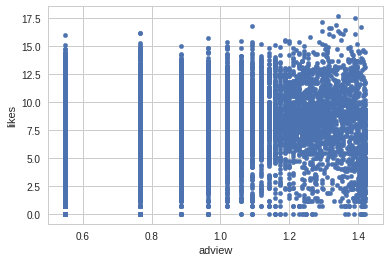

In [583]:
train.plot(kind='scatter', x='adview', y='likes')

temp = train.loc[train.adview > 0.95]
train = train.loc[train.adview <= 0.95] 

In [482]:
train.head()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,E,F,G,H,dayofweek,year,month
1,0.786520,10.827413,4.493387,1.091565,1.914633,4.719273,0,0,0,1,0,0,0,0,5,2016,10
2,0.558661,11.174794,3.546517,0.000000,1.088596,3.899119,0,0,1,0,0,0,0,0,5,2016,7
4,0.558661,9.001576,0.705631,0.000000,0.000000,2.936094,0,0,0,1,0,0,0,0,2,2016,6
7,0.558661,15.591326,4.471613,2.786660,0.689151,3.358106,0,0,0,0,1,0,0,0,0,2016,8
8,0.558661,26.292461,9.935444,5.191802,7.363111,5.264541,0,0,0,0,0,1,0,0,4,2015,11


In [584]:
train['v_l_r'] = train['views'] / train['likes']
train['v_dur_r'] = train['views'] / train['duration']
train['l_dis_r'] = train['likes'] / train['dislikes']
train['l_dur_r'] = train['likes'] / train['duration']
train['l_dur_p'] = train['likes'] * train['duration']
train['v_dur_p'] = train['views'] * train['duration']

/home/raunaq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/raunaq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raunaq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [585]:
train.head()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,...,H,dayofweek,year,month,v_l_r,v_dur_r,l_dis_r,l_dur_r,l_dur_p,v_dur_p
0,1.317979,28.880356,11.538891,5.708492,6.609410,4.575166,0,0,0,0,...,0,2,2016,9,2.502871,6.312417,2.021355,2.522070,52.792345,132.132430
1,0.765389,10.855845,4.496306,1.091948,1.914925,4.693011,0,0,0,1,...,0,5,2016,10,2.414392,2.313194,4.117692,0.958085,21.101215,50.946605
2,0.548662,11.204879,3.548361,0.000000,1.088690,3.881853,0,0,1,0,...,0,5,2016,7,3.157762,2.886477,inf,0.914090,13.774217,43.495693
3,1.060302,27.014189,7.944709,4.946762,4.832820,4.266922,0,0,0,0,...,1,2,2016,7,3.400274,6.331071,1.606042,1.861930,33.899457,115.267445
4,0.548662,9.021953,0.705708,0.000000,0.000000,2.926692,0,0,0,1,...,0,2,2016,6,12.784264,3.082645,inf,0.241128,2.065389,26.404473


In [586]:
train = train.replace([np.inf, -np.inf], np.NaN)

In [587]:
train.v_l_r.fillna(train.v_l_r.mean(), inplace=True)
train.v_dur_r.fillna(train.v_dur_r.mean(), inplace=True)
train.l_dis_r.fillna(train.l_dis_r.mean(), inplace=True)
train.l_dur_r.fillna(train.l_dur_r.mean(), inplace=True)

In [588]:
train.shape

(14476, 23)

In [589]:
train.head()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,...,H,dayofweek,year,month,v_l_r,v_dur_r,l_dis_r,l_dur_r,l_dur_p,v_dur_p
0,1.317979,28.880356,11.538891,5.708492,6.609410,4.575166,0,0,0,0,...,0,2,2016,9,2.502871,6.312417,2.021355,2.522070,52.792345,132.132430
1,0.765389,10.855845,4.496306,1.091948,1.914925,4.693011,0,0,0,1,...,0,5,2016,10,2.414392,2.313194,4.117692,0.958085,21.101215,50.946605
2,0.548662,11.204879,3.548361,0.000000,1.088690,3.881853,0,0,1,0,...,0,5,2016,7,3.157762,2.886477,2.228963,0.914090,13.774217,43.495693
3,1.060302,27.014189,7.944709,4.946762,4.832820,4.266922,0,0,0,0,...,1,2,2016,7,3.400274,6.331071,1.606042,1.861930,33.899457,115.267445
4,0.548662,9.021953,0.705708,0.000000,0.000000,2.926692,0,0,0,1,...,0,2,2016,6,12.784264,3.082645,2.228963,0.241128,2.065389,26.404473


In [489]:
train.describe()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,...,H,dayofweek,year,month,v_l_r,v_dur_r,l_dis_r,l_dur_r,l_dur_p,v_dur_p
count,9512.000000,9512.000000,9512.000000,9512.000000,9512.000000,9512.000000,9512.000000,9512.000000,9512.000000,9512.000000,...,9512.000000,9512.000000,9512.000000,9512.000000,9512.000000,9512.000000,9512.000000,9512.000000,9512.000000,9512.000000
mean,0.651613,20.991665,6.734981,3.235061,3.445323,4.489240,0.028175,0.058663,0.042998,0.494954,...,0.033852,2.811291,2014.474453,6.677775,3.520500,4.755040,2.307198,1.518361,30.520009,94.963688
std,0.133360,5.999065,2.866832,1.827419,2.039740,0.713648,0.165481,0.235005,0.202864,0.500001,...,0.180858,1.910693,1.756727,3.284681,1.575635,1.487651,1.011577,0.678089,13.722428,31.853276
min,0.558661,4.739236,0.000000,0.000000,0.000000,1.770778,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2005.000000,1.000000,1.689490,1.087007,0.000000,0.000000,0.000000,11.632500
25%,0.558661,17.057904,4.799827,1.923874,1.914633,4.087841,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,2013.000000,4.000000,2.714296,3.677802,1.746159,1.041425,21.215073,73.902200
50%,0.558661,21.231444,6.791346,3.267934,3.478401,4.422906,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.000000,2015.000000,7.000000,3.166268,4.627598,2.100714,1.481751,30.643084,95.607164
75%,0.786520,25.226774,8.696627,4.549297,4.921723,4.871685,0.000000,0.000000,0.000000,1.000000,...,0.000000,4.000000,2016.000000,9.000000,3.753573,5.749363,2.474258,1.962805,40.104696,116.171179
max,0.915554,46.700064,16.147912,8.970833,8.976191,6.597042,1.000000,1.000000,1.000000,1.000000,...,1.000000,6.000000,2017.000000,12.000000,29.352665,16.854833,11.374585,5.673774,77.718823,214.153866


In [590]:
train['views_square'] = train.views.pow(2)

In [591]:
train['views_sqrt'] = train.views.pow(0.5)

In [592]:
train['views_permonth'] = train['views'] * train['month']

In [593]:
train.head()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,...,month,v_l_r,v_dur_r,l_dis_r,l_dur_r,l_dur_p,v_dur_p,views_square,views_sqrt,views_permonth
0,1.317979,28.880356,11.538891,5.708492,6.609410,4.575166,0,0,0,0,...,9,2.502871,6.312417,2.021355,2.522070,52.792345,132.132430,834.074979,5.374045,259.923207
1,0.765389,10.855845,4.496306,1.091948,1.914925,4.693011,0,0,0,1,...,10,2.414392,2.313194,4.117692,0.958085,21.101215,50.946605,117.849368,3.294821,108.558449
2,0.548662,11.204879,3.548361,0.000000,1.088690,3.881853,0,0,1,0,...,7,3.157762,2.886477,2.228963,0.914090,13.774217,43.495693,125.549311,3.347369,78.434152
3,1.060302,27.014189,7.944709,4.946762,4.832820,4.266922,0,0,0,0,...,7,3.400274,6.331071,1.606042,1.861930,33.899457,115.267445,729.766396,5.197518,189.099321
4,0.548662,9.021953,0.705708,0.000000,0.000000,2.926692,0,0,0,1,...,6,12.784264,3.082645,2.228963,0.241128,2.065389,26.404473,81.395628,3.003657,54.131715


train.loc[train.adview > 12] = train.adview.mean()

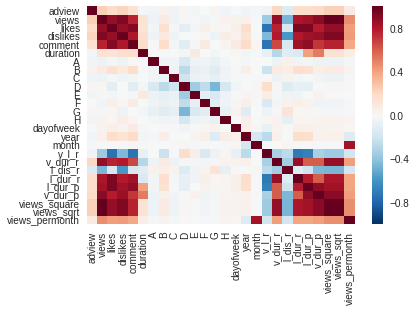

In [594]:
sns.heatmap(train.corr(method='spearman'))

In [595]:
train_y = train['adview']
train = train.drop(['adview'], axis = 1)

Random Forests
MAE : 0.129314
RMSE : 0.157106
Auc: 0.701689
R2: 0.251153


model_score 0.906490346166


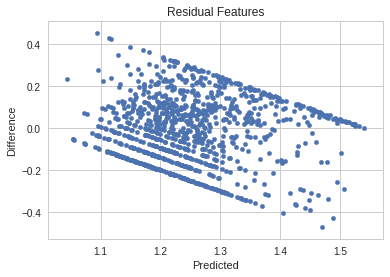

In [456]:
def display_metrics(y_test, y_pred):
    print ("MAE : %f" % metrics.mean_absolute_error(y_test, y_pred))
    print ("RMSE : %f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    #print ("NRMSE : %f" % np.mean(np.abs((y_test - y_pred)/y_test)) * 100)
    print ("Auc: %f" % metrics.auc(y_test, y_pred,reorder=True))
    print ("R2: %f" % metrics.r2_score(y_test, y_pred))
    #print ("fbeta: %f" % metrics.fbeta_score(y_test, y_pred, beta=2))
    print ("\n")
           
def model_train(model,X,y):
    # Split test, train
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_metrics(y_test, y_pred)
    
    print ('model_score', model.score(X_train, y_train))
    
    plt.figure(figsize= (50,10))
    preds = pd.DataFrame({"Predicted":model.predict(X_test), "true":y_test})
    preds["Difference"] = preds["true"] - preds["Predicted"]
    preds.plot(x = "Predicted", y = "Difference",kind = "scatter", title = "Residual Features")
    plt.show()
    
def training(X,y):   
    
    
    #Random Forests
    rand_clf = RandomForestRegressor(n_jobs=-1, bootstrap=True, n_estimators = 300)
    print ("Random Forests")
    model_train(rand_clf, X, y)

    #Ridge Regression
#    ridge_clf = Ridge(alpha=0.001, normalize=True)
#    print ("Ridge Regression")
#    model_train(ridge_clf, X, y)
    
    #Lasso Regression
#    lasso_clf = Lasso(alpha=0.001, normalize=True)
#    print ("Lasso Regression")
#    model_train(lasso_clf, X, y)
    
    #MLP Regression
#    mlp_clf = MLPRegressor(solver = 'lbfgs', alpha = 0.01, hidden_layer_sizes=(10,10), random_state= 1)
#    print ("MLP (NN)")
#    model_train(mlp_clf, X, y)
    
    
    return rand_clf

rand_reg = training(train, train_y)


rf = RandomForestRegressor(n_jobs=-1, bootstrap=True, n_estimators=300)
scores = []
for i in range(train.shape[1]):
    score = cross_val_score(rf, train.iloc[:, i:i+1], y_train, scoring="r2",
                              cv=3)
    scores.append((round(np.mean(score), 3)))
print (scores)

In [605]:
X_train, X_test, y_train, y_test = train_test_split(train,train_y,test_size=0.2, random_state = 5)

In [606]:
random_forest = RandomForestRegressor(n_jobs=-1, bootstrap=True, n_estimators=300)

rfe = RFE(random_forest, n_features_to_select=1)

rfe.fit(train, train_y)

print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), train.columns)))

In [607]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [608]:
y_pred = random_forest.predict(X_test)

In [609]:
random_forest.score(X_train, y_train)

0.89872661413456933

In [610]:
random_forest.score(X_test,y_test)

0.25309014117188899

In [611]:
# get Correlation Coefficient for each feature
coeff_df = DataFrame(X_train.columns)
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(random_forest.feature_importances_)

# preview
coeff_df

,Features,Coefficient Estimate
0,views,0.059359
1,likes,0.034903
2,dislikes,0.048055
3,comment,0.056938
4,duration,0.060295
5,A,0.003679
6,B,0.005816
7,C,0.002942
8,D,0.009353
9,E,0.006689


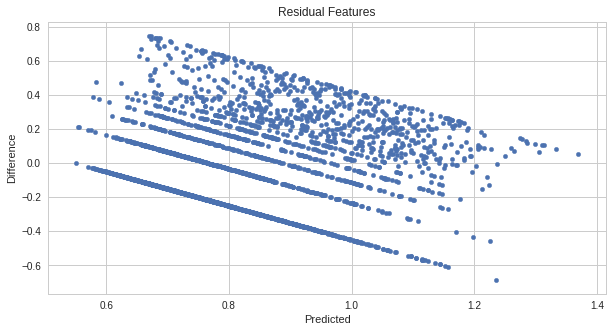

In [612]:
#Remaining Feature Set
plt.figure(figsize= (50,10))
preds = pd.DataFrame({"Predicted":random_forest.predict(X_test), "true":y_test})
preds["Difference"] = preds["true"] - preds["Predicted"]
preds.plot(x = "Predicted", y = "Difference",kind = "scatter", title = "Residual Features",figsize=(10,5))

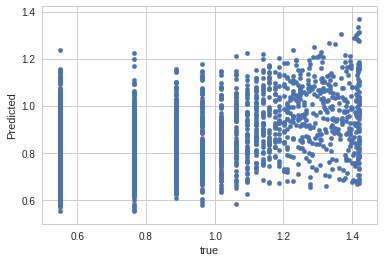

In [613]:
preds.plot(kind='scatter', x='true', y='Predicted')

In [76]:
rlasso = RandomizedLasso(alpha=0.025)

In [77]:
rlasso.fit(train, train_y)

RandomizedLasso(alpha=0.025, eps=2.2204460492503131e-16, fit_intercept=True,
        max_iter=500, memory=Memory(cachedir=None), n_jobs=1,
        n_resampling=200, normalize=True, pre_dispatch='3*n_jobs',
        precompute='auto', random_state=None, sample_fraction=0.75,
        scaling=0.5, selection_threshold=0.25, verbose=False)

In [79]:
print (sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
                 train.columns), reverse=True))

[(0.0, 'year'), (0.0, 'views_square'), (0.0, 'views_sqrt'), (0.0, 'views_permonth'), (0.0, 'views'), (0.0, 'v_l_r'), (0.0, 'v_dur_r'), (0.0, 'v_dur_p'), (0.0, 'month'), (0.0, 'likes'), (0.0, 'l_dur_r'), (0.0, 'l_dur_p'), (0.0, 'l_dis_r'), (0.0, 'duration'), (0.0, 'dislikes'), (0.0, 'dayofweek'), (0.0, 'comment'), (0.0, 'H'), (0.0, 'G'), (0.0, 'F'), (0.0, 'E'), (0.0, 'D'), (0.0, 'C'), (0.0, 'B'), (0.0, 'A')]


In [82]:
mine = MINE()
mic_scores = []
for i in range(train.shape[1]):
    mine.compute_score(train.iloc[:,i], train_y)
    m = mine.mic()
    mic_scores.append(m)

In [86]:
print (sorted(zip(mic_scores, train.columns),reverse=True))

[(0.11449266491930599, 'views_square'), (0.11449266491930599, 'views_sqrt'), (0.11449266491930599, 'views'), (0.09989441392499666, 'dislikes'), (0.07919194628136983, 'likes'), (0.0784375527414729, 'l_dis_r'), (0.0783142800114633, 'l_dur_p'), (0.07732382217001729, 'v_dur_p'), (0.07575273433519517, 'l_dur_r'), (0.075729139055869, 'v_dur_r'), (0.06471073965077961, 'v_l_r'), (0.06399579741368099, 'comment'), (0.06348123054117873, 'views_permonth'), (0.052722506658366815, 'year'), (0.042097766947722916, 'duration'), (0.037244565697785635, 'D'), (0.035249893543062044, 'G'), (0.03433694774103084, 'month'), (0.03155135250017935, 'F'), (0.03090919424685683, 'dayofweek'), (0.029052889713027497, 'E'), (0.02819688129699216, 'B'), (0.02061718811583538, 'A'), (0.014307010006821181, 'C'), (0.01086283201911779, 'H')]


In [87]:
train.columns

Index(['views', 'likes', 'dislikes', 'comment', 'duration', 'A', 'B', 'C', 'D',
       'E', 'F', 'G', 'H', 'dayofweek', 'year', 'month', 'v_l_r', 'v_dur_r',
       'l_dis_r', 'l_dur_r', 'l_dur_p', 'v_dur_p', 'views_square',
       'views_sqrt', 'views_permonth'],
      dtype='object')

In [88]:
columns = ['views', 'likes', 'dislikes', 'comment', 'duration',
        'F', 'G', 'year', 'month', 'v_l_r', 'v_dur_r',
       'l_dis_r', 'l_dur_r', 'l_dur_p', 'v_dur_p', 'views_square',
       'views_sqrt', 'views_permonth']

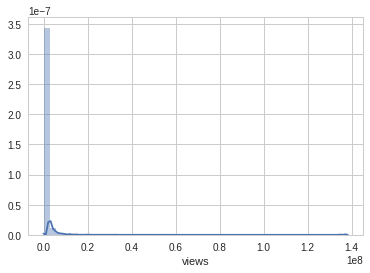

In [224]:
sns.distplot(train['views'])

In [226]:
x = boxcox(train['views'])[0]
train['views'] = x

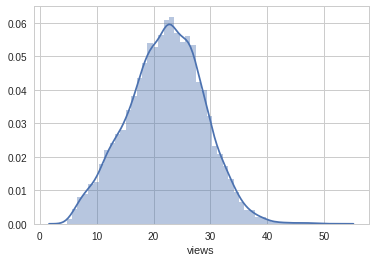

In [322]:
sns.distplot(train['views'])

In [92]:
X_train, X_test, y_train, y_test = train_test_split(train,train_y,test_size=0.2, random_state = 1)

In [93]:
rf = RandomForestRegressor(n_jobs=-1, bootstrap=True, n_estimators=300)

In [94]:
rf.fit(X_train[columns], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [95]:
rf.score(X_train[columns], y_train)

0.89461318439557347

In [97]:
rf.score(X_test[columns], y_test)

0.26879815552417985

In [323]:
est = GradientBoostingRegressor(n_estimators=250, learning_rate=0.1, random_state=7, max_depth=5)

In [324]:
est.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=250,
             presort='auto', random_state=7, subsample=1.0, verbose=0,
             warm_start=False)

In [325]:
est.score(X_test, y_test)

0.21594402614897559

In [326]:
est.score(X_train, y_train)

0.50696928585164336

In [327]:
print (sorted(zip(est.feature_importances_, train.columns),reverse=True))

[(0.091842352994287571, 'year'), (0.090658944919889614, 'views_permonth'), (0.085396269079131948, 'l_dis_r'), (0.084170681835608968, 'v_l_r'), (0.071260022323396552, 'duration'), (0.070404739813331188, 'v_dur_p'), (0.065116636376796252, 'comment'), (0.057915073644166468, 'v_dur_r'), (0.057859483897831979, 'l_dur_r'), (0.046749802767955526, 'l_dur_p'), (0.045679719545455987, 'dislikes'), (0.037423448011143626, 'likes'), (0.032404971112182525, 'views_square'), (0.031472491517966682, 'views_sqrt'), (0.030799604950201672, 'views'), (0.027228180264470814, 'month'), (0.027043015424826119, 'dayofweek'), (0.0081482238151808634, 'G'), (0.0080415233105084281, 'E'), (0.007777523804106329, 'F'), (0.0062397266478331458, 'B'), (0.0055646350265262448, 'D'), (0.0050267124048254371, 'A'), (0.0028994730541793239, 'H'), (0.0028767434581967659, 'C')]


In [328]:
X_train.columns

Index(['views', 'likes', 'dislikes', 'comment', 'duration', 'A', 'B', 'C', 'D',
       'E', 'F', 'G', 'H', 'dayofweek', 'year', 'month', 'v_l_r', 'v_dur_r',
       'l_dis_r', 'l_dur_r', 'l_dur_p', 'v_dur_p', 'views_square',
       'views_sqrt', 'views_permonth'],
      dtype='object')